In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Load your data
df = pd.read_csv('Toddler Autism dataset July 2018.csv')

# Data Cleaning and transformation (same as before)
df = df.drop_duplicates()
df.columns = df.columns.str.strip()
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=np.number).columns] = imputer.fit_transform(df.select_dtypes(include=np.number))
imputer_cat = SimpleImputer(strategy='most_frequent')
df[df.select_dtypes(include='object').columns] = imputer_cat.fit_transform(df.select_dtypes(include='object'))

# Feature engineering (Encoding)
label_cols = df.select_dtypes(include='object').columns
ordinal_encoder = OrdinalEncoder()
df[label_cols] = ordinal_encoder.fit_transform(df[label_cols])

# Sampling Data (SMOTEENN)
X = df.drop(columns=['Class/ASD Traits'])
y = df['Class/ASD Traits']
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize numerical features after splitting
numerical_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Introduce noise to the features
noise_factor = 0.10
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Introduce label noise
np.random.seed(42)  # For reproducibility
noise_probability = 0.05
y_train_noisy = y_train.copy()
y_test_noisy = y_test.copy()
flip_train = np.random.rand(len(y_train)) < noise_probability
flip_test = np.random.rand(len(y_test)) < noise_probability
y_train_noisy[flip_train] = 1 - y_train_noisy[flip_train]
y_test_noisy[flip_test] = 1 - y_test_noisy[flip_test]

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(penalty='l2', C=0.1, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=5, min_samples_split=4, random_state=42),
    "XGBoost": XGBClassifier(max_depth=3, min_child_weight=5, gamma=0.1, eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(max_depth=3, min_child_weight=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(max_depth=3, random_state=42),
    "Support Vector Machine": SVC(C=1, gamma=0.01, probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7)
}

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, roc_auc, recall, f1

# Initialize a dictionary to store the results
results = {}

# Evaluate all models and store results in the dictionary
for model_name, model in models.items():
    accuracy, roc_auc, recall, f1 = evaluate_model(model, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)
    results[model_name] = {
        "Test Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "Recall": recall,
        "F1 Score": f1
    }

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by="Test Accuracy", ascending=False))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:54:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 348, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4396
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475410 -> initscore=-0.098440
[LightGBM] [Info] Start training from score -0.098440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC AUC curves for all models
def plot_roc_curve(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    
    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



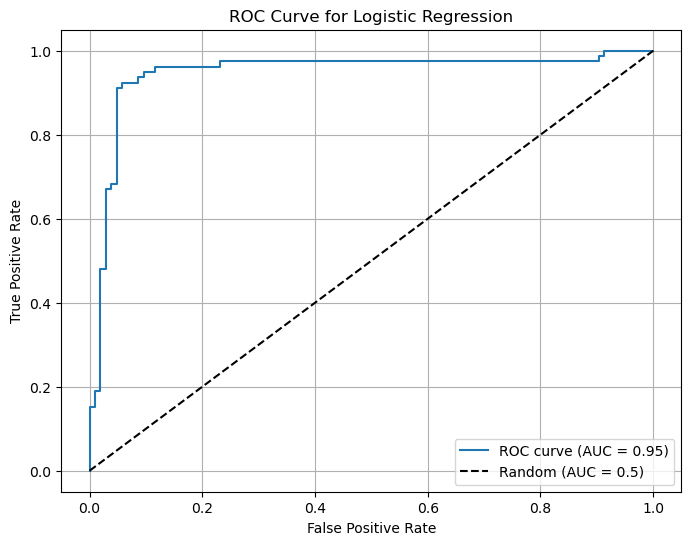

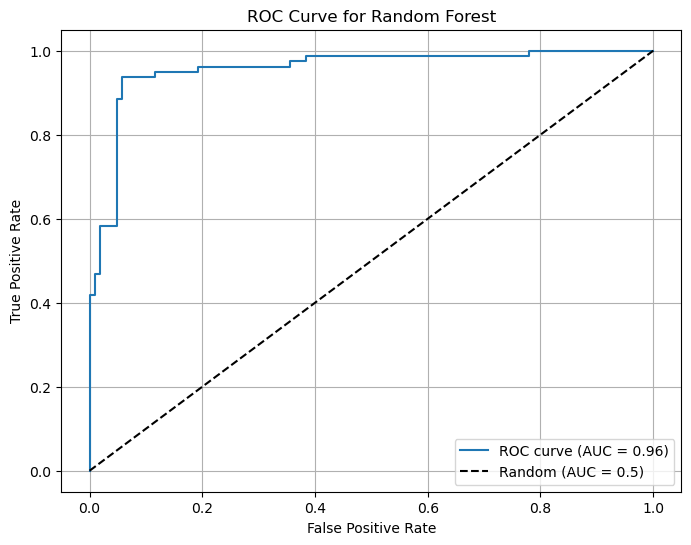

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:54:18] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


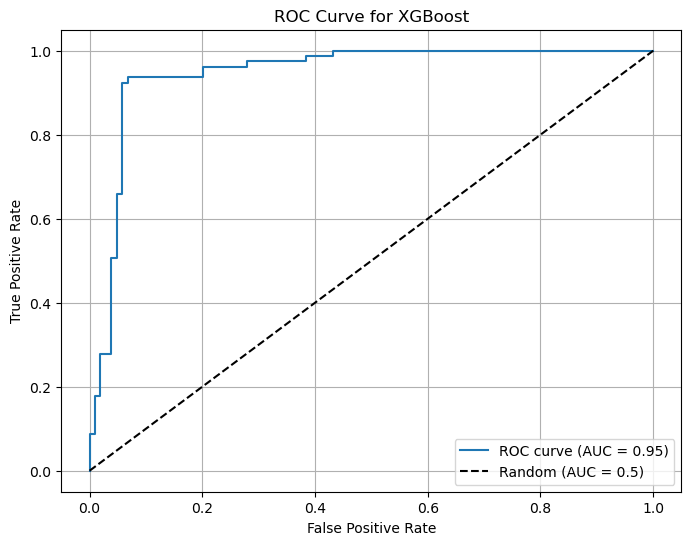

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 348, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4396
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475410 -> initscore=-0.098440
[LightGBM] [Info] Start training from score -0.098440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

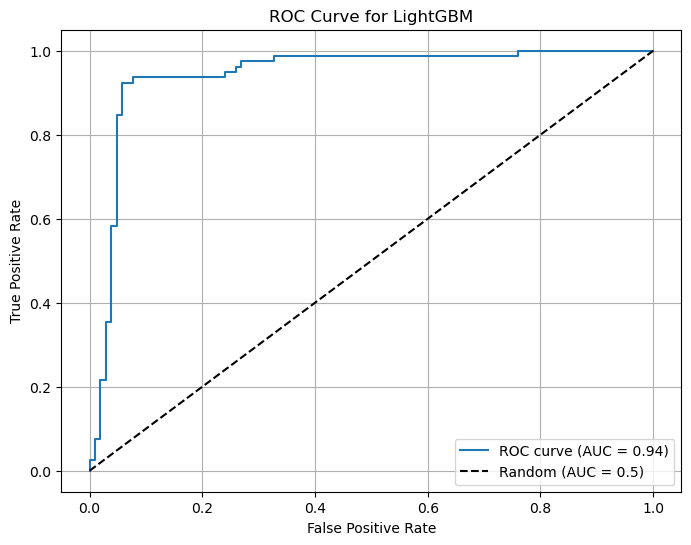

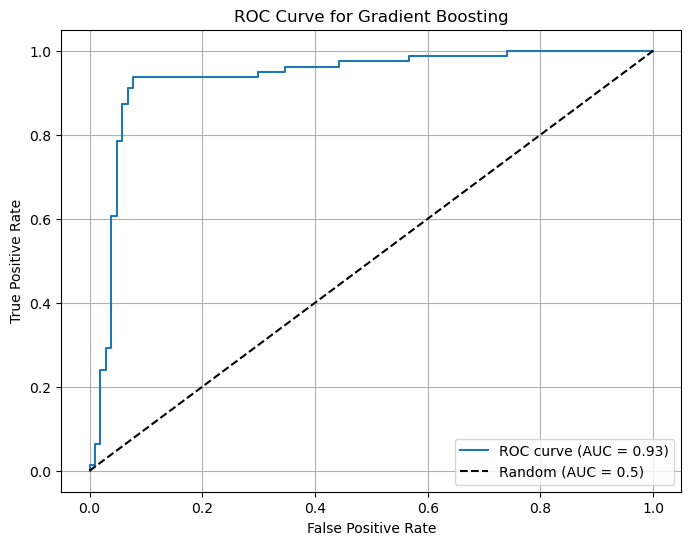

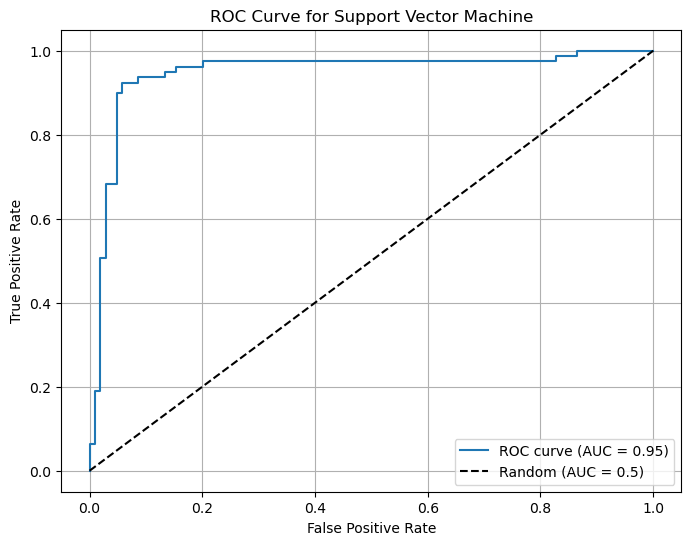

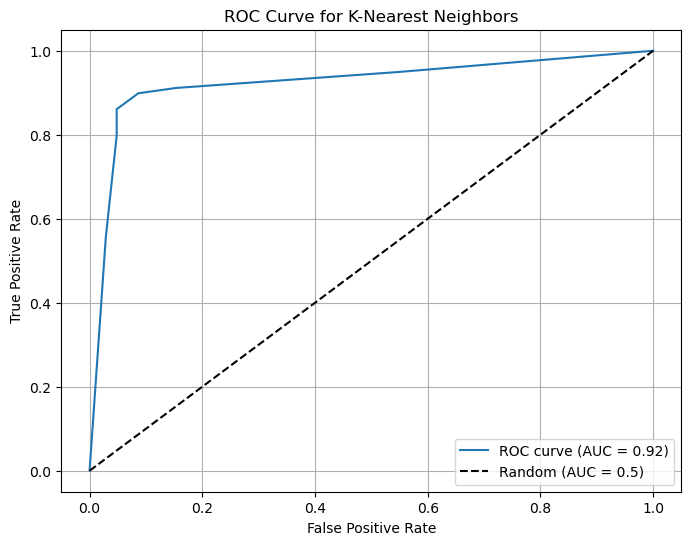

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC AUC curve for each model separately
def plot_separate_roc_curve(models, X_train, y_train, X_test, y_test):
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Get the probabilities for the positive class (index 1)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

# Call the function to plot ROC AUC curves for each model separately
plot_separate_roc_curve(models, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:54:20] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 348, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4396
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475410 -> initscore=-0.098440
[LightGBM] [Info] Start training from score -0.098440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

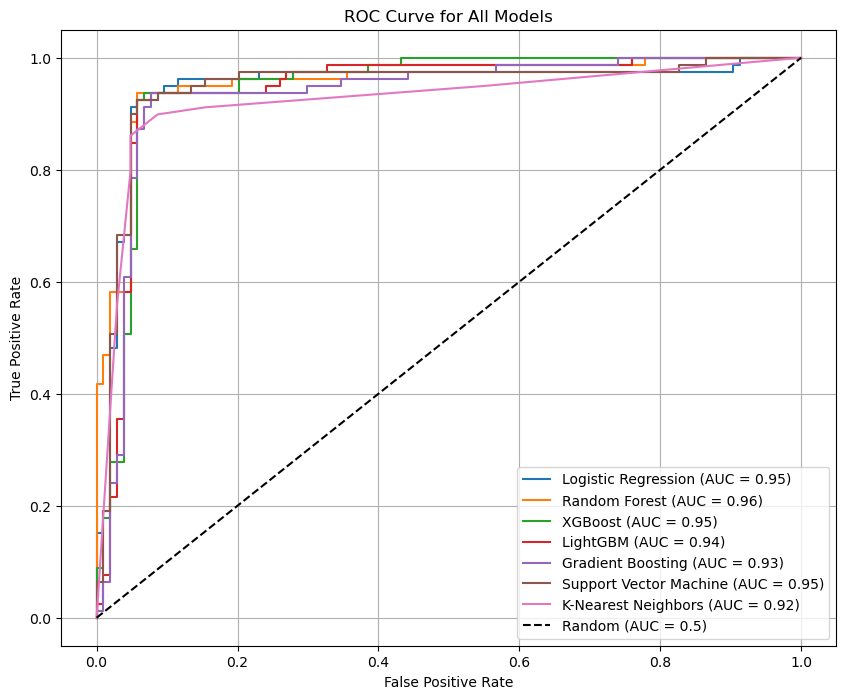

In [4]:
# Call the function to plot ROC AUC curves
plot_roc_curve(models, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)